### Import Packages

In [18]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import preprocessing, utils, losses, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Embedding, SpatialDropout1D
import numpy as np
from pickle import dump, load
from matplotlib import pyplot, cm
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.cluster import DBSCAN
import datetime
from geopy.geocoders import Nominatim
pd.options.display.float_format = "{:,.2f}".format

### Load Data & Process

In [2]:
def min_max_scale(vals):
    min_val = min(vals)
    max_val = max(vals)
    scaled_vals = []
    for val in vals:
        val = val[0]
        scaled_val = ((val - min_val) / (max_val - min_val))[0]
        scaled_vals.append(scaled_val)
    return scaled_vals

# load data
weather_dataframe = pd.read_csv('65 Years of Weather Data Bangladesh (1948 - 2013).csv')

# generate rainfall percentage using min-max scaling
rainfall_percentage = []
for val in min_max_scale(weather_dataframe[['Rainfall']].values):
    rainfall_percentage.append(round(val * 100))
weather_dataframe['Rainfall Percentage'] = rainfall_percentage

weather_dataframe.sample(n=10)

,Station Names,Year,Month,Latitude,Longitude,Max Temp,Min Temp,Rainfall,Relative Humidity,Wind Speed,Cloud Coverage,Bright Sunshine,Rainfall Percentage
8578,Hatiya,1988,7,22.29,91.13000,33.0,25.6,747.000000,89.000000,4.000000,6.5,3.800000,36.0
11053,Khulna,1985,5,22.80,89.58000,36.0,24.6,158.000000,81.000000,3.900000,5.1,8.600000,8.0
9277,Ishurdi,1970,9,24.12,89.04000,34.4,25.7,261.000000,84.000000,3.700000,6.4,5.220690,13.0
46,Barisal,1995,1,22.70,90.36000,29.0,10.7,1.000000,73.000000,0.400000,1.7,6.800000,0.0
2738,Chandpur,2004,12,23.26,90.67000,29.5,17.1,2.000000,80.000000,0.100000,0.7,5.600000,0.0
5002,Cox's Bazar,1952,6,21.46,91.98000,32.8,24.8,809.000000,88.000000,3.238889,6.1,4.033962,39.0
3838,Chuadanga,2001,11,23.65,88.81667,33.0,19.5,14.333333,80.333333,0.300000,2.2,7.444444,1.0
16923,Sandwip,1969,4,22.50,91.46000,34.6,25.0,171.000000,78.000000,2.200000,3.1,8.051852,8.0
19709,Sylhet,2009,1,24.88,91.93000,29.0,14.4,0.000000,75.000000,2.800000,1.2,6.500000,0.0
20730,Teknaf,1994,2,20.87,92.26000,33.2,17.0,0.000000,58.000000,1.700000,0.7,8.900000,0.0


### Outlier Detaction

Total Outliers: 1


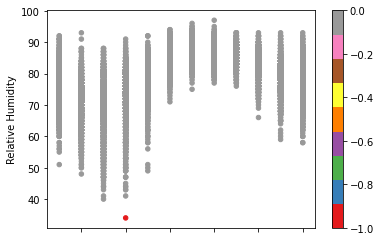

In [3]:
# outlier detection for "Relative Humidity"
outlier_detection = DBSCAN(
    metric='euclidean', # euclidean method for distance calculation
    eps=5, # maximum distance between two samples for one to be considered as in the neighborhood 
    min_samples=10 #number of samples in a neighborhood for a point to be considered as a core point
)
clusters = outlier_detection.fit_predict(weather_dataframe[['Relative Humidity']])
weather_dataframe.plot.scatter(x='Month', y='Relative Humidity', c=clusters, cmap=cm.get_cmap('Set1'), colorbar=True)

# clean outliers
outlier_indexes = []
for i in range(0, len(clusters)):
    if clusters[i] != 0: outlier_indexes.append(i)
weather_dataframe = weather_dataframe.drop(outlier_indexes)
print('Total Outliers: ' + str(len(outlier_indexes)))

Total Outliers: 11


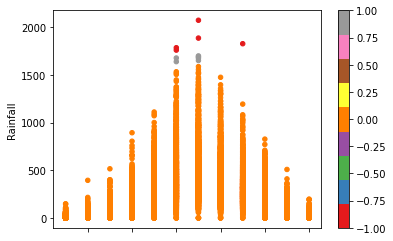

In [4]:
# outlier detection for "Rainfall"
outlier_detection = DBSCAN(
    metric='euclidean', # euclidean method for distance calculation
    eps=50, # maximum distance between two samples for one to be considered as in the neighborhood 
    min_samples=5 #number of samples in a neighborhood for a point to be considered as a core point
)
clusters = outlier_detection.fit_predict(weather_dataframe[['Rainfall']])
weather_dataframe.plot.scatter(x='Month', y='Rainfall', c=clusters, cmap=cm.get_cmap('Set1'), colorbar=True)

# clean outliers
outlier_indexes = []
for i in range(0, len(clusters)):
    if clusters[i] != 0: outlier_indexes.append(i)
weather_dataframe = weather_dataframe.drop(outlier_indexes)
print('Total Outliers: ' + str(len(outlier_indexes)))

### Define Test and Train Data

In [5]:
# separate x and y data
X = np.array(weather_dataframe[['Latitude', 'Longitude', 'Year', 'Month']].values)
Y = np.array(weather_dataframe[['Min Temp', 'Max Temp', 'Rainfall', 'Relative Humidity', 'Wind Speed', 'Cloud Coverage', 'Bright Sunshine', 'Rainfall Percentage']].values)

input_dim = X.shape[1]
output_dim = Y.shape[1]

# split train and test data
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.05)

### Deep Learning Algorithms

In [6]:
# define and compile the model
model = Sequential()
model.add(Dense(100, input_dim=input_dim, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(output_dim))
model.compile(loss="mse", optimizer="adam", metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               500       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                3232      
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 264       
Total params: 3,996
Trainable params: 3,996
Non-trainable params: 0
_________________________________________________________________


In [7]:
# fit the model
history = model.fit(x_train, y_train, batch_size=25, epochs=250, validation_split = 0.3)

Epoch 1/250
562/562 [==============================] - 3s 6ms/step - loss: 7828.3892 - accuracy: 0.5403 - val_loss: 6808.1616 - val_accuracy: 0.5560
Epoch 2/250
562/562 [==============================] - 3s 5ms/step - loss: 7289.4995 - accuracy: 0.5534 - val_loss: 6830.3857 - val_accuracy: 0.5560
Epoch 3/250
562/562 [==============================] - 2s 3ms/step - loss: 7309.9429 - accuracy: 0.5534 - val_loss: 6908.8003 - val_accuracy: 0.5560
Epoch 4/250
562/562 [==============================] - 2s 4ms/step - loss: 7278.3760 - accuracy: 0.5534 - val_loss: 6903.9810 - val_accuracy: 0.5560
Epoch 5/250
562/562 [==============================] - 1s 2ms/step - loss: 7253.2480 - accuracy: 0.5534 - val_loss: 6784.2036 - val_accuracy: 0.5560
Epoch 6/250
562/562 [==============================] - 1s 2ms/step - loss: 7250.7231 - accuracy: 0.5534 - val_loss: 6774.9453 - val_accuracy: 0.5560
Epoch 7/250
562/562 [==============================] - 1s 2ms/step - loss: 7220.8052 - accuracy: 0.5534 - 

Epoch 56/250
562/562 [==============================] - 1s 2ms/step - loss: 3075.8750 - accuracy: 0.8770 - val_loss: 2781.1357 - val_accuracy: 0.8871
Epoch 57/250
562/562 [==============================] - 1s 2ms/step - loss: 3061.6821 - accuracy: 0.8759 - val_loss: 2815.4231 - val_accuracy: 0.8775
Epoch 58/250
562/562 [==============================] - 1s 2ms/step - loss: 3088.9875 - accuracy: 0.8745 - val_loss: 2847.0493 - val_accuracy: 0.8860
Epoch 59/250
562/562 [==============================] - 1s 2ms/step - loss: 3065.3035 - accuracy: 0.8802 - val_loss: 2799.5789 - val_accuracy: 0.8532
Epoch 60/250
562/562 [==============================] - 1s 2ms/step - loss: 3037.4304 - accuracy: 0.8782 - val_loss: 2970.2141 - val_accuracy: 0.8278
Epoch 61/250
562/562 [==============================] - 2s 3ms/step - loss: 3070.2620 - accuracy: 0.8780 - val_loss: 3006.4497 - val_accuracy: 0.8868
Epoch 62/250
562/562 [==============================] - 1s 2ms/step - loss: 3076.8252 - accuracy: 0.

562/562 [==============================] - 2s 4ms/step - loss: 2806.8721 - accuracy: 0.8858 - val_loss: 2603.1799 - val_accuracy: 0.8939
Epoch 165/250
562/562 [==============================] - 1s 2ms/step - loss: 2866.8538 - accuracy: 0.8824 - val_loss: 2583.8835 - val_accuracy: 0.8938
Epoch 166/250
562/562 [==============================] - 1s 2ms/step - loss: 2810.3823 - accuracy: 0.8867 - val_loss: 2570.1296 - val_accuracy: 0.8939
Epoch 167/250
562/562 [==============================] - 2s 3ms/step - loss: 2849.8457 - accuracy: 0.8857 - val_loss: 2948.2952 - val_accuracy: 0.8592
Epoch 168/250
562/562 [==============================] - 1s 2ms/step - loss: 2824.3152 - accuracy: 0.8853 - val_loss: 2601.1462 - val_accuracy: 0.8959
Epoch 169/250
562/562 [==============================] - 2s 3ms/step - loss: 2821.9802 - accuracy: 0.8870 - val_loss: 2590.7944 - val_accuracy: 0.8944
Epoch 170/250
562/562 [==============================] - 2s 4ms/step - loss: 2826.4363 - accuracy: 0.8831 - 

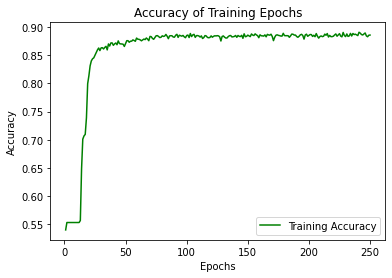

In [8]:
pyplot.plot(range(1, len(history.history['accuracy']) + 1), history.history['accuracy'], 'g', label='Training Accuracy')
pyplot.title('Accuracy of Training Epochs')
pyplot.xlabel('Epochs')
pyplot.ylabel('Accuracy')
pyplot.legend()
pyplot.show()

In [9]:
# save the trained model
model.save('model.h5')

### Load the Saved Model and Test

In [10]:
# load the model
model = keras.models.load_model('model.h5')

# bulk prediction
test_dataframe = []
for i in range(0, 20):
    test_x = x_test[i]
    test_y = y_test[i]
    pred_y = model.predict(np.array([test_x]))[0]
    test_dataframe.append([
        str(round(test_x[0], 2)), str(round(test_x[1], 2)), int(test_x[2]), int(test_x[3]),
        str(round(test_y[0], 1)), str(round(pred_y[0], 1)),
        str(round(test_y[1], 1)), str(round(pred_y[1], 1)),
        str(round(test_y[2], 1)), str(round(pred_y[2], 1)),
        str(round(test_y[3], 1)), str(round(pred_y[3], 1)),
        str(round(test_y[4], 1)), str(round(pred_y[4], 1)),
        str(round(test_y[5], 1)), str(round(pred_y[5], 1)),
        str(round(test_y[6], 1)), str(round(pred_y[6], 1)),
        str(round(test_y[7], 1)), str(round(pred_y[7], 1))
    ])

test_dataframe = pd.DataFrame(test_dataframe)
test_dataframe.columns = [
    'Latitude', 'Longitude', 'Year', 'Month',
    'Min Temp', 'Min Temp (Predicted)',
    'Max Temp', 'Max Temp (Predicted)',
    'Rainfall', 'Rainfall (Predicted)',
    'Relative Humidity', 'Relative Humidity (Predicted)',
    'Wind Speed', 'Wind Speed (Predicted)',
    'Cloud Coverage', 'Cloud Coverage (Predicted)',
    'Bright Sunshine', 'Bright Sunshine (Predicted)',
    'Rainfall Percentage', 'Rainfall Percentage (Predicted)'
]

def dataframe_style(data):
    return ['background-color: rgba(0, 0, 0, 0.25);' for i in data]
test_dataframe.style.apply(dataframe_style, axis=0, subset=[
    'Min Temp', 'Min Temp (Predicted)',
    'Rainfall', 'Rainfall (Predicted)',
    'Wind Speed', 'Wind Speed (Predicted)',
    'Bright Sunshine', 'Bright Sunshine (Predicted)'
])

,Latitude,Longitude,Year,Month,Min Temp,Min Temp (Predicted),Max Temp,Max Temp (Predicted),Rainfall,Rainfall (Predicted),Relative Humidity,Relative Humidity (Predicted),Wind Speed,Wind Speed (Predicted),Cloud Coverage,Cloud Coverage (Predicted),Bright Sunshine,Bright Sunshine (Predicted),Rainfall Percentage,Rainfall Percentage (Predicted)
0,25.63,88.66,1979,7,25.9,25.8,32.2,34.5,422.0,390.4,85.0,86.8,0.9,1.2,5.9,5.7,4.3,4.0,20.0,18.0
1,24.15,89.55,1994,4,21.6,18.9,38.5,34.0,163.0,99.4,75.0,72.3,1.5,1.0,3.3,1.7,7.2,7.1,8.0,5.3
2,22.34,91.79,1957,12,14.9,15.3,28.7,29.1,1.0,11.8,72.0,75.0,1.3,0.4,0.5,1.2,8.0,6.9,0.0,1.6
3,25.72,89.26,1954,11,17.2,16.9,30.8,30.7,0.0,16.6,81.3,78.5,0.9,0.4,0.5,1.4,7.9,7.2,0.0,1.4
4,22.64,91.64,2007,5,25.2,22.9,38.0,35.1,349.0,304.2,83.0,80.0,1.5,1.6,4.0,3.4,7.8,5.9,17.0,14.8
5,23.48,91.19,2009,4,24.2,19.7,36.8,34.8,48.0,107.1,79.0,74.1,3.0,1.1,3.2,1.8,8.4,7.2,2.0,5.7
6,24.75,90.41,2000,4,21.7,18.9,35.0,34.1,320.0,101.7,82.0,72.5,2.2,1.0,4.4,1.7,6.7,7.1,15.0,5.4
7,22.34,91.79,2011,4,23.9,20.6,33.6,35.4,133.0,117.3,78.0,75.6,5.5,1.2,3.5,1.9,7.7,7.3,6.0,6.1
8,23.78,90.39,2012,6,26.9,26.1,36.7,36.4,175.0,462.4,78.0,85.8,2.6,1.8,6.2,5.1,2.9,4.4,8.0,21.7
9,23.01,91.37,1983,11,20.0,20.9,33.1,32.4,12.0,64.9,80.0,80.3,0.6,0.6,2.8,1.9,7.7,8.0,1.0,1.9


In [11]:
y_pred = model.predict(x_test)
print("Explain variance score =", metrics.explained_variance_score(y_test, y_pred)) 
print("R2 score =", metrics.r2_score(y_test, y_pred))

Explain variance score = 0.5990368019506913
R2 score = 0.5651894208395838


### Load the Current Location and Predict Weather of Next 12 Months

In [14]:
%%javascript
// load latitude, longitude of current location
navigator.geolocation.getCurrentPosition(currentPosition => {
    IPython.notebook.kernel.execute(`
        current_position = {
            'latitude': ${currentPosition.coords.latitude},
            'longitude': ${currentPosition.coords.longitude}
        }
    `)
})

<IPython.core.display.Javascript object>

In [17]:
# bulk prediction
result_dataframe = []
for i in range(0, 12):
    month = datetime.datetime.now().month + i
    year = datetime.datetime.now().year
    if month > 12:
        month = month - 12
        year = year + 1
        
    pred = model.predict(np.array([[
        current_position['latitude'],
        current_position['longitude'],
        year,
        month
    ]]))[0]
    result_dataframe.append([str(month) + '/' + str(year), pred[0], pred[1], pred[2], pred[3], pred[4], pred[5], pred[6], pred[7]])
    
result_dataframe = pd.DataFrame(result_dataframe)
result_dataframe.columns = [
    'Month',
    'Min Temp',
    'Max Temp',
    'Rainfall',
    'Relative Humidity',
    'Wind Speed',
    'Cloud Coverage',
    'Bright Sunshine',
    'Rainfall Percenatge'
]

location = Nominatim(user_agent="Weather Forecasting").reverse(str(current_position['latitude']) + ', ' + str(current_position['longitude']))
print('Weather Forecasting for:\nLocation: ' + location.address + '\nLatitude: ' + str(current_position['latitude']) + '\nLongitude: ' + str(current_position['longitude']))
result_dataframe

Weather Forecasting for:
Location: দক্ষিণ বাড্ডা, গুলশান, ঢাকা, ঢাকা জেলা, ঢাকা বিভাগ, 1212, Bangladesh
Latitude: 23.7746161
Longitude: 90.4237766


,Month,Min Temp,Max Temp,Rainfall,Relative Humidity,Wind Speed,Cloud Coverage,Bright Sunshine,Rainfall Percenatge
0,9/2020,26.41,35.79,338.55,88.22,1.26,5.00,5.46,15.84
1,10/2020,24.21,35.01,196.65,85.08,0.96,3.58,6.73,8.89
2,11/2020,22.01,34.23,54.75,81.95,0.67,2.15,7.99,1.94
3,12/2020,15.25,30.36,8.49,80.58,0.53,1.08,7.23,0.77
4,1/2021,11.86,30.91,1.19,73.56,0.24,-0.25,7.22,0.13
5,2/2021,13.91,32.03,14.07,73.14,0.47,0.22,7.32,0.91
6,3/2021,16.61,33.57,37.26,72.93,0.72,0.84,7.47,2.20
7,4/2021,19.14,34.55,94.28,73.41,0.98,1.62,7.22,5.07
8,5/2021,22.61,35.45,257.45,78.67,1.38,3.16,6.10,12.45
9,6/2021,26.27,36.79,449.14,85.89,1.76,5.05,4.50,21.04


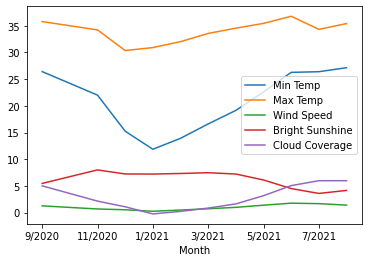

In [16]:
# plot data
ax = pyplot.gca()
result_dataframe.plot(kind='line', x='Month', y='Min Temp', ax=ax)
result_dataframe.plot(kind='line', x='Month', y='Max Temp', ax=ax)
result_dataframe.plot(kind='line', x='Month', y='Wind Speed', ax=ax)
result_dataframe.plot(kind='line', x='Month', y='Bright Sunshine', ax=ax)
result_dataframe.plot(kind='line', x='Month', y='Cloud Coverage', ax=ax)
pyplot.show()